In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
tf.compat.v1.enable_eager_execution()

### Loading data

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_dataset = keras.utils.image_dataset_from_directory(
            '/content/drive/MyDrive/ZINDI-image/train_TF',
            validation_split=0.2,
            subset="training",
            label_mode = 'int',
            seed = 1000,
            image_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE)
test_dataset = keras.utils.image_dataset_from_directory(
            '/content/drive/MyDrive/ZINDI-image/train_TF',
            validation_split=0.2,
            subset="validation",
            label_mode = 'int',
            seed = 1000,
            image_size=(IMG_SIZE, IMG_SIZE),
            batch_size=1)

# For performance improvement according to TF
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 1619 files belonging to 2 classes.
Using 1296 files for training.
Found 1619 files belonging to 2 classes.
Using 323 files for validation.


### Transfer learning

In [3]:
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.4)(x)
output = keras.layers.Dense(2, activation="softmax")(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])
model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D

In [4]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#### Fitting

In [5]:
history = model.fit(
    train_dataset,
    epochs=20
)

Epoch 1/20
41/41 [==============================] - 139s 584ms/step - loss: 0.1259 - accuracy: 0.9468
Epoch 2/20
41/41 [==============================] - 23s 551ms/step - loss: 0.0599 - accuracy: 0.9823
Epoch 3/20
41/41 [==============================] - 23s 551ms/step - loss: 0.0148 - accuracy: 0.9969
Epoch 4/20
41/41 [==============================] - 23s 569ms/step - loss: 0.0040 - accuracy: 0.9992
Epoch 5/20
41/41 [==============================] - 23s 560ms/step - loss: 0.0080 - accuracy: 0.9977
Epoch 6/20
41/41 [==============================] - 23s 551ms/step - loss: 0.0151 - accuracy: 0.9961
Epoch 7/20
41/41 [==============================] - 23s 555ms/step - loss: 0.0056 - accuracy: 0.9985
Epoch 8/20
41/41 [==============================] - 23s 565ms/step - loss: 0.0438 - accuracy: 0.9877
Epoch 9/20
41/41 [==============================] - 23s 561ms/step - loss: 0.0166 - accuracy: 0.9938
Epoch 10/20
41/41 [==============================] - 23s 550ms/step - loss: 0.0137 - accur

In [6]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

323/323 [==============================] - 23s 62ms/step - loss: 0.0365 - accuracy: 0.9938


{'accuracy': 0.9938080310821533, 'loss': 0.03648565337061882}

### Getting misclassified images

In [7]:
images = []  # to store the misclassified images
preds = []
labels = []
good_one_images = []  # to store the rightly classified images of label 1
good_zero_images = []  # to store the rightly classified images of label 0
one_count = 0
zero_count = 0
for x, y in tqdm(test_dataset):
  temp_pred = np.argmax(model.predict(x))  # predicted 1 if the value is bigger than 0.5
  temp_y = y.numpy().item()
  if temp_pred != temp_y:
    images.append(x)
    preds.append(temp_pred)
    labels.append(temp_y)
  if temp_pred == temp_y and temp_y == 1 and one_count < 15:  # getting rightly classified images of label 1
    good_one_images.append(x)
    one_count += 1
  if temp_pred == temp_y and temp_y == 0 and zero_count < 15:  # getting rightly classified images of label 0
    good_zero_images.append(x)
    zero_count += 1

100%|██████████| 323/323 [00:40<00:00,  7.89it/s]


In [8]:
len(images)  # total number of misclassified images

2

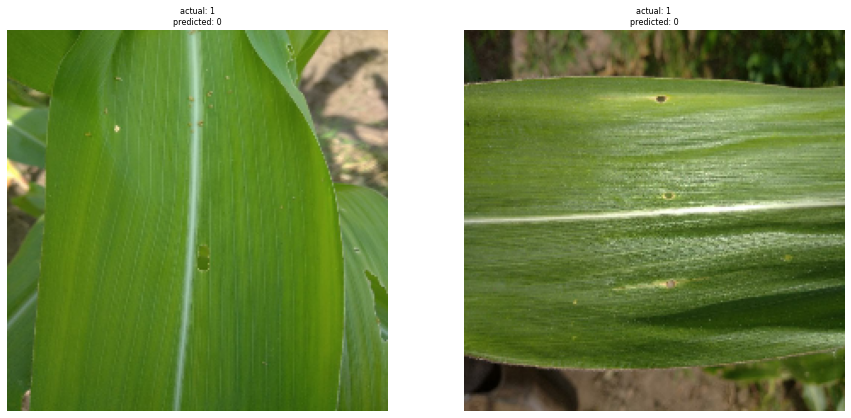

In [9]:
# 0: not damaged, 1: damaged
plt.subplots(figsize=(15, 10))
for i in range(len(images)):
    img = images[i]
    plt.subplot(1, len(images), i+1)
    plt.imshow(np.squeeze(img).astype(np.uint8))
    plt.axis('off')
    plt.title("actual: %d\npredicted: %d" % (labels[i], preds[i]), fontsize=8)

### Generating heatmap

In [10]:
# function that generates an image superimposed with heatmap
def print_heatmap(image):
  # Setting up a model that returns the last convolutional output
  last_conv_layer_name = "top_conv"
  classifier_layer_names = [
                            'global_average_pooling2d',
                            'dropout', 
                            'dense'
  ]
  last_conv_layer = model.get_layer(last_conv_layer_name)
  last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)


  # Reapplying the classifier on top of the last convolutional output
  classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input
  for layer_name in classifier_layer_names:
      x = model.get_layer(layer_name)(x)
  classifier_model = keras.Model(classifier_input, x)


  # Retrieving the gradients of the top predicted class
  with tf.GradientTape() as tape:
      last_conv_layer_output = last_conv_layer_model(image)  
      tape.watch(last_conv_layer_output)
      preds = classifier_model(last_conv_layer_output)
      top_pred_index = tf.argmax(preds[0])
      top_class_channel = preds[:, top_pred_index]
  grads = tape.gradient(top_class_channel, last_conv_layer_output)


  # Gradient pooling and channel-importance weighting
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  for i in range(pooled_grads.shape[-1]):
      last_conv_layer_output[:, :, i] *= pooled_grads[i]
  heatmap = np.mean(last_conv_layer_output, axis=-1)


  # Heatmap post-processing
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)


  # Superimposing the heatmap on the original picture
  img = np.squeeze(image)
  heatmap = np.uint8(255 * heatmap)
  jet = cm.get_cmap('viridis')  # this was supposed to be cmap('jet'), but i changed it to 'viridis' which is the same one as the heatmap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)
  superimposed_img = jet_heatmap * 1 + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)


  # Plotting
  plt.subplots(figsize=(15, 10));
  plt.subplot(1, 3, 1);
  plt.imshow(np.squeeze(image).astype(np.uint8));
  plt.title("Original");
  plt.axis('off');
  plt.subplot(1, 3, 2);
  plt.colorbar(plt.imshow(heatmap), fraction=0.046, pad=0.04);
  plt.clim(0,250);
  plt.title("Heatmap");
  plt.axis('off');
  plt.subplot(1, 3, 3);
  plt.imshow(superimposed_img);
  plt.title("Superimposed");
  plt.axis('off');

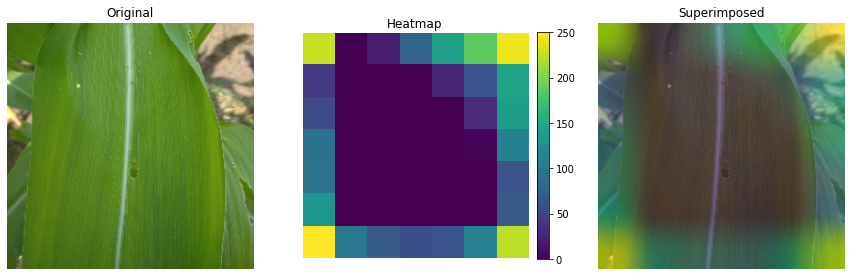

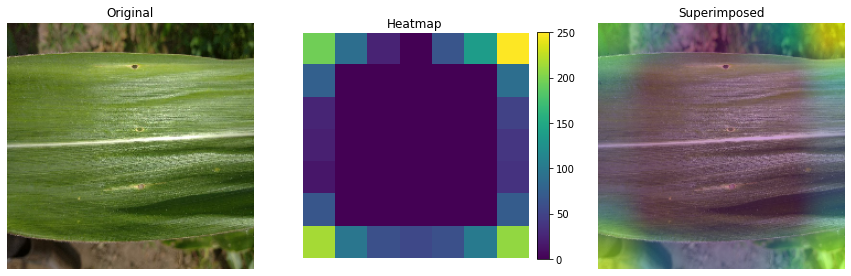

In [11]:
for image in images:  # misclassified images that will be used for heatmap
  print_heatmap(image)

In [12]:
for image in good_one_images:  # rightly classified images of label 1 that will be used for heatmap
  print_heatmap(image)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
for image in good_zero_images:  # rightly classified images of label 0 that will be used for heatmap
  print_heatmap(image)

Output hidden; open in https://colab.research.google.com to view.